# EBL Calculations for CTA

In [3]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp2d, RectBivariateSpline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from astropy.io import ascii
from astropy.table import Table

In [4]:
%matplotlib inline

## Defs

In [5]:
class EBL:
    def __init__(self, model):

        self.model_file = model

        self._import_model()

        self.h = 0.7  # hubble constant
        self.omega_m = 0.3  # matter density
        self.omega_l = 0.7  # lambda density

        self.interpolation = interp2d(
            self._model.index.to_numpy()*1e6,
            np.asfarray(self._model.columns.to_numpy()),
            z=self.model.to_numpy().T,
            kind="linear"
        )

    def _import_model(self):

        df = pd.read_csv(
            self.model_file, comment="#", delim_whitespace=True, index_col=0
        )

        # set index name of DataFrame
        df.index.name = "energy"

        self._model = df

    @property
    def model(self):
        return self._model

    def get(self, energy, z):
        """Get EBL value at given energy and redshift"""

        return self.interpolation(energy, z)[0]

    def abs(self, energy, z):
        """Get absorption at given energy and redshift"""

        return np.exp(-1 * self.get(energy, z))


class Spectrum:
    """Base class for a spectrum"""

    def __init__(self, ebl_model=None):

        if ebl_model is not None:
            self.ebl = EBL(ebl_model)
        else:
            self.ebl = None


class PowerLaw(Spectrum):
    """Power Law Spectrum"""

    def __init__(self, prefactor, pivot, index, z=None, ebl_model=None):

        Spectrum.__init__(self, ebl_model)

        self.z = z
        self.prefactor = prefactor
        self.pivot = pivot
        self.index = index

    def S(self, energy):
        """Calculate the spectrum at given energy and optional redshift"""

        if self.z and self.ebl:
            absorption = self.ebl.abs(energy, self.z)
        else:
            absorption = 1

        return self.prefactor * ((energy / self.pivot) ** self.index) * absorption
    
    
    def export_file_function(self, output_file, n_points=100):
        
        energies = np.logspace(
            np.log10(self.ebl._model.index.min()), 
            np.log10(self.ebl._model.index.max()),
            n_points
        ) * 1e6
        
        spectrum = self.S(energies)  # Model in Tev, -> MeV
        
        t = Table()
        t["energy [MeV]"] = energies
        t["sepctrum [ph/cm2/s/MeV]"] = spectrum
        
        ascii.write(t, output_file, overwrite=True)
        
        xml = f"""<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<source_library title="source library">
  <source name="GRB" type="PointSource">
    <spectrum type="FileFunction" file="{output_file}">
        <parameter name="Normalization" scale="1.0" value="1.0" min="0.0" max="1000.0" free="1"/>
    </spectrum>
    <spatialModel type="PointSource">
      <parameter name="RA" value="83.6331" scale="1" min="-360" max="360" free="0" />
      <parameter name="DEC" value="22.0145" scale="1" min="-90" max="90" free="0" />
    </spatialModel>
  </source>
  <source name="CTABackgroundModel" type="CTAIrfBackground" instrument="CTA">
    <spectrum type="PowerLaw">
      <parameter name="Prefactor" value="1" error="0" scale="1" min="0.001" max="1000" free="1" />
      <parameter name="Index" value="0" error="0" scale="1" min="-5" max="5" free="1" />
      <parameter name="PivotEnergy" value="1" scale="1000000" min="0.01" max="1000000" free="0" />
    </spectrum>
  </source>
</source_library>
"""
        
        # write xml to file
        with open(output_file.replace(".dat", ".xml"), "w") as f:
            f.write(xml)
        



In [6]:
spec = PowerLaw(
    prefactor=5.7e-7,   
    pivot=1000,
    index=-2.1,
    z=0.2,
    ebl_model="tau_franceschini08.out"
)

In [7]:
spec.export_file_function("./powerlaw.dat", 100)

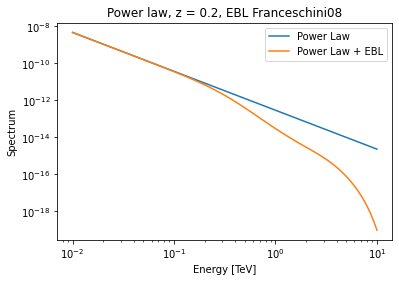

In [8]:
z = 0.2

spec = PowerLaw(
    prefactor=5.7e-7,   # ph / cm2 / s / MeV
    pivot=1000,         # MeV
    index=-2.1,
    z=z,
    ebl_model="tau_franceschini08.out"
)

E = np.logspace(-2, 1, 100)  

S = [spec.S(e*1e6) for e in E]  # TeV to MeV

pl = 5.7e-7 * ((E*1e6 / 1000) ** -2.1)

plt.loglog(E, pl, label="Power Law")
plt.loglog(E, S, label="Power Law + EBL")
plt.title(f"Power law, z = {z}, EBL Franceschini08")
plt.xlabel("Energy [TeV]")
plt.ylabel("Spectrum")
plt.legend()
plt.show()

In [142]:
f = EBL("./tau_franceschini08.out")


In [118]:
f.interpolation(0.286229, 0.02526316)[0]

0.0431381

In [75]:
# Get Tau, or the absorption coefficient, at a given energy (TeV) and redshift (z)

f.get(0.286229, 0.02526316)

0.0431381

In [76]:
# Get the absorption fraction at a given energy (TeV) and redshift (z)

f.abs(0.286229, 0.02526316)

0.9577791116380981

## Sanity Check
- compare original model to interpolated model

Text(0, 0.5, 'Spectrum')

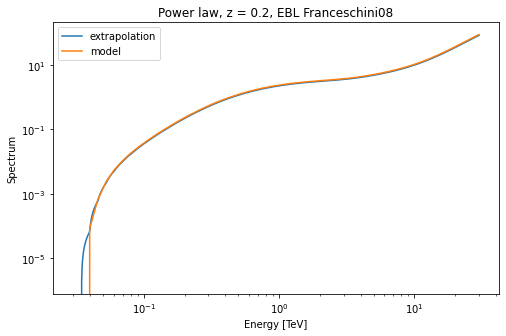

In [145]:
z = 0.2
z_model = "0.20842105"

spec = PowerLaw(
    prefactor=5.7e-7,
    pivot=1000,
    index=-2.1,
    z=z,
    ebl_model="tau_franceschini08.out"
)

model = spec.ebl.model[z_model]

E = np.logspace(np.log10(0.03), np.log10(30), 1000)

S = [spec.ebl.get(e, z) for e in E]

fig, ax = plt.subplots(figsize=(8,5))

ax.loglog(E, S, label="extrapolation")
ax.loglog(model.keys(), model.values, label="model")
ax.set_title(f"Power law, z = {z}, EBL Franceschini08")
ax.set_xlabel("Energy [TeV]")
ax.legend()
ax.set_ylabel("Spectrum")

In [8]:
data = {}

for Y in np.asfarray(f.model.columns.to_numpy()):
    data[Y] = {}
    for X in np.asfarray(f.model.index):
        data[Y][X] = f.get(X, Y)
        
pd.DataFrame.from_dict(data)

,0.010000,0.025263,0.040526,0.055789,0.071053,0.086316,0.101579,0.116842,0.132105,0.147368,...,0.550000,0.600000,0.650000,0.700000,0.750000,0.800000,0.850000,0.900000,0.950000,1.000000
0.030000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003105,0.004631,0.006528,0.008826,0.011555,0.014746,0.018427,0.022630,0.027383,0.032717
0.034542,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006859,0.009771,0.013213,0.017188,0.021705,0.026768,0.032384,0.038558,0.045297,0.052607
0.039771,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000001,0.000009,0.000016,0.000006,0.000018,...,0.014089,0.019288,0.025180,0.031714,0.038835,0.046492,0.054631,0.063199,0.072143,0.081410
0.045792,4.893400e-07,0.000008,0.000019,0.000033,0.000058,0.000102,0.000160,0.000210,0.000200,0.000289,...,0.024733,0.032727,0.041598,0.051237,0.061533,0.072377,0.083657,0.095263,0.107086,0.119015
0.052725,2.892780e-05,0.000085,0.000153,0.000240,0.000370,0.000528,0.000710,0.000878,0.000958,0.001228,...,0.039637,0.050989,0.063446,0.076844,0.091019,0.105811,0.121055,0.136590,0.152251,0.167878
0.060708,1.020360e-04,0.000278,0.000483,0.000753,0.001079,0.001443,0.001854,0.002278,0.002564,0.003128,...,0.059845,0.075095,0.091733,0.109572,0.128425,0.148103,0.168420,0.189188,0.210220,0.231328
0.069899,2.352650e-04,0.000629,0.001115,0.001679,0.002308,0.003000,0.003796,0.004631,0.005257,0.006267,...,0.088257,0.108611,0.130728,0.154402,0.179429,0.205601,0.232713,0.260560,0.288935,0.317632
0.080481,4.442830e-04,0.001230,0.002131,0.003126,0.004201,0.005424,0.006804,0.008195,0.009344,0.011034,...,0.127252,0.154467,0.183962,0.215502,0.248852,0.283777,0.320041,0.357408,0.395645,0.434514
0.092665,7.990780e-04,0.002152,0.003635,0.005229,0.007021,0.009007,0.011148,0.013312,0.015341,0.017992,...,0.181453,0.217644,0.256786,0.298651,0.343008,0.389627,0.438277,0.488729,0.540752,0.594115
0.106694,1.300580e-03,0.003432,0.005711,0.008241,0.011058,0.014075,0.017240,0.020637,0.023932,0.027898,...,0.257113,0.306166,0.359012,0.415322,0.474770,0.537027,0.601768,0.668662,0.737385,0.807607


In [9]:
f.model

,0.01,0.02526316,0.04052632,0.05578947,0.07105263,0.08631579,0.10157895,0.11684211,0.13210526,0.14736842,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.
energy,,,,,,,,,,,,,,,,,,,,,
0.030000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003105,0.004631,0.006528,0.008826,0.011555,0.014746,0.018427,0.022630,0.027383,0.032717
0.034542,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006859,0.009771,0.013213,0.017188,0.021705,0.026768,0.032384,0.038558,0.045297,0.052607
0.039771,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000001,0.000009,0.000016,0.000006,0.000018,...,0.014089,0.019288,0.025180,0.031714,0.038835,0.046492,0.054631,0.063199,0.072143,0.081410
0.045792,4.893400e-07,0.000008,0.000019,0.000033,0.000058,0.000102,0.000160,0.000210,0.000200,0.000289,...,0.024733,0.032727,0.041598,0.051237,0.061533,0.072377,0.083657,0.095263,0.107086,0.119015
0.052725,2.892780e-05,0.000085,0.000153,0.000240,0.000370,0.000528,0.000710,0.000878,0.000958,0.001228,...,0.039637,0.050989,0.063446,0.076844,0.091019,0.105811,0.121055,0.136590,0.152251,0.167878
0.060708,1.020360e-04,0.000278,0.000483,0.000753,0.001079,0.001443,0.001854,0.002278,0.002564,0.003128,...,0.059845,0.075095,0.091733,0.109572,0.128425,0.148103,0.168420,0.189188,0.210220,0.231328
0.069899,2.352650e-04,0.000629,0.001115,0.001679,0.002308,0.003000,0.003796,0.004631,0.005257,0.006267,...,0.088257,0.108611,0.130728,0.154402,0.179429,0.205601,0.232713,0.260560,0.288935,0.317632
0.080481,4.442830e-04,0.001230,0.002131,0.003126,0.004201,0.005424,0.006804,0.008195,0.009344,0.011034,...,0.127252,0.154467,0.183962,0.215502,0.248852,0.283777,0.320041,0.357408,0.395645,0.434514
0.092665,7.990780e-04,0.002152,0.003635,0.005229,0.007021,0.009007,0.011148,0.013312,0.015341,0.017992,...,0.181453,0.217644,0.256786,0.298651,0.343008,0.389627,0.438277,0.488729,0.540752,0.594115
